## Ryan Tietjen
## Sep 2024

## Loading Data

In [1]:
from data_processing import get_file_names
dir = "Data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
print(get_file_names(dir))

['Data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt', 'Data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt', 'Data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']


In [2]:
from data_processing import get_file_names
from data_processing import get_lines_from_txt_file
train_lines = get_lines_from_txt_file(dir, "train.txt")
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [3]:
len(train_lines)

210040

## Process Data

In [4]:
from data_processing import split_text_into_abstracts
dir = "Data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
train_data = split_text_into_abstracts(dir, "train.txt")
validation_data = split_text_into_abstracts(dir, "dev.txt")
test_data = split_text_into_abstracts(dir, "test.txt") 
train_data[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [5]:
import pandas as pd
train_df = pd.DataFrame(train_data)
validation_df = pd.DataFrame(validation_data)
test_df = pd.DataFrame(test_data)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [6]:
train_sentences = train_df["text"].tolist()
validation_sentences = validation_df["text"].tolist()
test_sentences = test_df["text"].tolist()


In [7]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

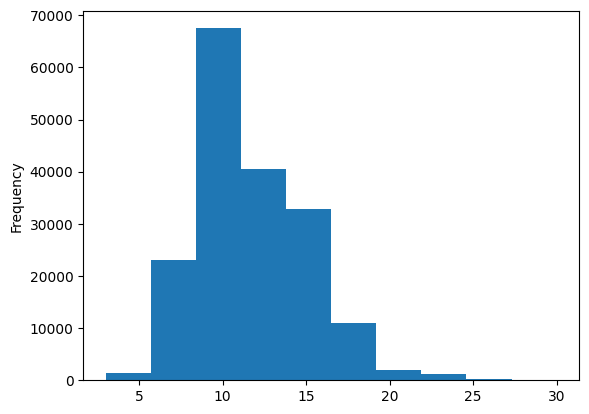

In [8]:
import matplotlib.pyplot as plt  
train_df.total_lines.plot.hist()

## Encode data (with one-hot encoding)

In [9]:
from data_processing import one_hot_encode_labels

one_hot_train_labels, one_hot_validation_labels, one_hot_test_labels = one_hot_encode_labels(train_df["target"], validation_df["target"], test_df["target"])


In [10]:
from data_processing import encode_labels

train_labels, validation_labels, test_labels = encode_labels(train_df["target"], validation_df["target"], test_df["target"])
print(train_labels[:15])

[3 2 2 2 2 2 4 4 4 4 4 1 0 0 3]


## Baseline model (Naive Bayes)

In [11]:
# Baseline model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [12]:
from utils import classification_metrics
validation_predictions = model_0.predict(validation_sentences)
score = model_0.score(X=validation_sentences,
              y=validation_labels)
results = classification_metrics(validation_predictions, validation_labels)
print(score)
print(results)

0.7218323844829869
{'accuracy': 0.7218323844829869, 'precision': 0.7186466952323352, 'recall': 0.7218323844829869, 'f1_score': 0.6989250353450294}


## Vectorize/Embed Data

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import TextVectorization 
import random
output_seq_len = int(np.percentile([len(sentence.split()) for sentence in train_sentences], 95))
print(output_seq_len)
text_vectorizer = TextVectorization(max_tokens=68000, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences
text_vectorizer.adapt(train_sentences)

random_sentence = random.choice(train_sentences)
print(text_vectorizer([random_sentence]))

55
tf.Tensor(
[[   23    17  1040     6  1482     2   432  2743     4     2 16935   141
      4   195 11991   325    22    59  6689   432    85 10047     3     6
    228   180   408     5 16935  1148   141     4   195  1003   148     7
  40825 12215  8743 12680  3829   383     6    48    58   463  1846     0
      0     0     0     0     0     0     0]], shape=(1, 55), dtype=int64)


In [14]:
vocab = text_vectorizer.get_vocabulary()
token_embedding = layers.Embedding(input_dim=len(vocab), # length of vocabulary
                               output_dim=128, 
                               mask_zero=True,
                               name="token_embedding")

token_embedding(text_vectorizer([random_sentence]))

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[ 0.04179224,  0.04516942,  0.02847962, ...,  0.04973254,
         -0.02105661,  0.03991559],
        [ 0.0313173 , -0.02053701,  0.00133342, ..., -0.01465509,
         -0.02264044,  0.04180281],
        [-0.01867668, -0.02151964,  0.01936481, ..., -0.02356553,
          0.04104474,  0.01175828],
        ...,
        [ 0.01914275, -0.00501233, -0.03701773, ...,  0.02408874,
         -0.00883336, -0.00546668],
        [ 0.01914275, -0.00501233, -0.03701773, ...,  0.02408874,
         -0.00883336, -0.00546668],
        [ 0.01914275, -0.00501233, -0.03701773, ...,  0.02408874,
         -0.00883336, -0.00546668]]], dtype=float32)>

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, one_hot_train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_sentences, one_hot_validation_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, one_hot_test_labels))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


## Model 1 - Conv1D with token embeddings

In [16]:
from model_creation import create_model
model1 = create_model(1, 5, token_embedding, character_embed=None, text_vectorizer=text_vectorizer)
print(model1.summary())

c:\Users\ryan4\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:934: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
model1_history = model1.fit(train_dataset,
                    steps_per_epoch = int(0.1 * len(train_dataset)), # Only train on 10% of data
                    epochs = 1,
                    validation_data = validation_dataset,
                    validation_steps=int(0.1 * len(validation_dataset))) # Only validate on 10% of data

562/562 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - accuracy: 0.5211 - loss: 1.1656 - val_accuracy: 0.7397 - val_loss: 0.6939


In [18]:
model1_results = classification_metrics(tf.argmax(model1.predict(validation_dataset), axis = 1),
                                        validation_labels)
print(model1_results)

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
{'accuracy': 0.7390440884416788, 'precision': 0.7410627437883502, 'recall': 0.7390440884416788, 'f1_score': 0.7340832820905253}


# Model 2 - Feature extraction with pretrained token embeddings

In [19]:
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
tf_hub_embedding_layer = hub.KerasLayer(module_url,
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [20]:
model2 = create_model(2, 5, token_embed=tf_hub_embedding_layer)

In [21]:
# Get a summary of the model
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer                 │ (None, 512)            │             0 │
│ (EmbeddingLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model2_history = model2.fit(train_dataset,
                    steps_per_epoch = int(0.1 * len(train_dataset)), # Only train on 10% of data
                    epochs = 1,
                    validation_steps=int(0.1 * len(validation_dataset))) # Only validate on 10% of data

562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5868 - loss: 1.0842


In [23]:
model2_results = classification_metrics(tf.argmax(model2.predict(validation_dataset), axis = 1),
                                        validation_labels)
print(model2_results)

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
{'accuracy': 0.6925724877532107, 'precision': 0.6990540523155901, 'recall': 0.6925724877532107, 'f1_score': 0.6905830754241783}


## Model 3 - Conv1D with character embeddings

In [24]:
from utils import split_sentences_by_characters
train_data_by_character = split_sentences_by_characters(train_sentences)
validation_data_by_character = split_sentences_by_characters(validation_sentences)
test_data_by_character = split_sentences_by_characters(test_sentences)
train_data_by_character[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [25]:
char_lens = [len(sentence) for sentence in train_sentences]
output_seq_char_len = int(np.percentile([len(sentence) for sentence in train_sentences], 95))
print(output_seq_char_len)
print(np.mean(char_lens))

290
149.3662574983337


In [26]:
char_vectorizer = TextVectorization(max_tokens=72,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation")
char_vectorizer.adapt(train_data_by_character)

character_embedding = layers.Embedding(input_dim=72, # length of vocabulary
                               output_dim=25, #from figure 1 in https://arxiv.org/pdf/1612.05251.pdf 
                               mask_zero=False,
                               name="character_embedding")


In [27]:
model3 = create_model(1, 5, token_embed=character_embedding, character_embed=None, text_vectorizer=char_vectorizer)
print(model3.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ character_embedding (Embedding) │ (None, 290, 25)        │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,189 (39.80 KB)

 Trainable params: 10,189 (39.80 KB)

 Non-trainable params: 0 (0.00 B)

None


In [28]:
train_dataset_by_chars = tf.data.Dataset.from_tensor_slices((train_data_by_character, one_hot_train_labels))
validation_dataset_by_chars = tf.data.Dataset.from_tensor_slices((validation_data_by_character, one_hot_validation_labels))
test_dataset_by_chars = tf.data.Dataset.from_tensor_slices((test_data_by_character, one_hot_test_labels))

train_dataset_by_chars = train_dataset_by_chars.batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset_by_chars = validation_dataset_by_chars.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_by_chars = test_dataset_by_chars.batch(32).prefetch(tf.data.AUTOTUNE)

print(train_dataset_by_chars)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


In [29]:
model3_history = model3.fit(train_dataset_by_chars,
                    steps_per_epoch = int(0.1 * len(train_dataset_by_chars)), # Only train on 10% of data
                    epochs = 1,
                    validation_data=validation_dataset_by_chars,
                    validation_steps = int(0.1 * len(validation_dataset_by_chars))) # Only validate on 10% of data

562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3435 - loss: 1.4667 - val_accuracy: 0.4132 - val_loss: 1.3799


In [30]:
model3_results = classification_metrics(tf.argmax(model3.predict(validation_dataset_by_chars), axis = 1),
                                        validation_labels)
print(model3_results)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
{'accuracy': 0.42860452800211835, 'precision': 0.3422931334685984, 'recall': 0.42860452800211835, 'f1_score': 0.36112728158243534}


c:\Users\ryan4\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model 4 - Hybrid Embedding Layer (pretrained tokens + character embeddings)

In [31]:
model4 = create_model(3, 5, tf_hub_embedding_layer, character_embedding, char_vectorizer)
print(model4.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 290)       │          0 │ input_layer_4[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer_1   │ (None, 512)       │          0 │ input_layer_3[0]… │
│ (EmbeddingLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ character_embedding │ (None, 290, 25)   │      1,800 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ embedding_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     14,848 │ character_embedd… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hybrid              │ (None, 192)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 192)       │          0 │ hybrid[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 200)       │     38,600 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5)         │      1,005 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 121,917 (476.24 KB)

 Trainable params: 121,917 (476.24 KB)

 Non-trainable params: 0 (0.00 B)

None


In [32]:
model4_data_train = tf.data.Dataset.from_tensor_slices((train_sentences, train_data_by_character))
model4_labels_train = tf.data.Dataset.from_tensor_slices(one_hot_train_labels)
model4_dataset_train = tf.data.Dataset.zip((model4_data_train, model4_labels_train)).batch(32).prefetch(tf.data.AUTOTUNE)

model4_data_validation = tf.data.Dataset.from_tensor_slices((validation_sentences, validation_data_by_character))
model4_labels_validation = tf.data.Dataset.from_tensor_slices(one_hot_validation_labels)
model4_dataset_validation = tf.data.Dataset.zip((model4_data_validation, model4_labels_validation)).batch(32).prefetch(tf.data.AUTOTUNE)

In [33]:
model4_history = model4.fit(model4_dataset_train,
                              steps_per_epoch=int(0.1 * len(model4_dataset_train)),
                              epochs=1,
                              validation_data=model4_dataset_validation,
                              validation_steps=int(0.1 * len(model4_dataset_validation)))

562/562 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step - accuracy: 0.5305 - loss: 1.1443 - val_accuracy: 0.6928 - val_loss: 0.7980


In [34]:
model4_results = classification_metrics(tf.argmax(model4.predict(model4_dataset_validation), axis = 1),
                                        validation_labels)
print(model4_results)

945/945 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step
{'accuracy': 0.6884350589169866, 'precision': 0.7004193938387422, 'recall': 0.6884350589169866, 'f1_score': 0.6865813071116874}


## Model 5 - Token/character/positional embeddings 

In [35]:
train_lines_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
validation_lines_one_hot = tf.one_hot(validation_df["line_number"].to_numpy(), depth=15)
test_lines_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [36]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
validation_total_lines_one_hot = tf.one_hot(validation_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [37]:
model5 = create_model(4, 5, tf_hub_embedding_layer, character_embedding, char_vectorizer)
print(model5.summary())

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 290)       │          0 │ input_layer_6[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer_2   │ (None, 512)       │          0 │ input_layer_5[0]… │
│ (EmbeddingLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ character_embedding │ (None, 290, 25)   │      1,800 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     65,664 │ embedding_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     14,848 │ character_embedd… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hybrid              │ (None, 192)       │          0 │ dense_7[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number         │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines         │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     49,408 │ hybrid[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │        512 │ line_number[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │        672 │ total_lines[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tribrid             │ (None, 320)       │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ dense_9[0][0],    │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 5)         │      1,605 │ tribrid[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 134,509 (525.43 KB)

 Trainable params: 134,509 (525.43 KB)

 Non-trainable params: 0 (0.00 B)

None


In [38]:
model5_data_train = tf.data.Dataset.from_tensor_slices((train_lines_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_data_by_character)) # train chars
model5_labels_train = tf.data.Dataset.from_tensor_slices(one_hot_train_labels) # train labels
model5_dataset_train = tf.data.Dataset.zip((model5_data_train, model5_labels_train)).batch(32).prefetch(tf.data.AUTOTUNE) # combine data and labels

model5_data_validation = tf.data.Dataset.from_tensor_slices((validation_lines_one_hot,
                                                              validation_total_lines_one_hot,
                                                              validation_sentences,
                                                              validation_data_by_character))
model5_labels_validation = tf.data.Dataset.from_tensor_slices(one_hot_validation_labels)
model5_dataset_validation = tf.data.Dataset.zip((model5_data_validation, model5_labels_validation)).batch(32).prefetch(tf.data.AUTOTUNE)

In [39]:
model5_history = model5.fit(model5_dataset_train,
                              steps_per_epoch=int(0.1 * len(model5_dataset_train)),
                              epochs=1,
                              validation_data=model5_dataset_validation,
                              validation_steps=int(0.1 * len(model5_dataset_validation)))

562/562 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.6224 - loss: 1.2218 - val_accuracy: 0.8065 - val_loss: 0.9843


In [40]:
model5_results = classification_metrics(tf.argmax(model5.predict(model5_dataset_validation), axis = 1),
                                        validation_labels)
print(model5_results)

945/945 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step
{'accuracy': 0.7964716006884681, 'precision': 0.8033286264304929, 'recall': 0.7964716006884681, 'f1_score': 0.7944163451519092}
